# Baseline Model - Toxic Comment Classification

* load data and preprocess
* define train test split
* define architecture and compile the model
* train the model
* evaluate the model


## Multilabel Logistic Regression

Multi-label classification assigns to each sample a set of target labels. Toxic comments can have one or multiple of the following labels:

* toxic
* severe_toxic
* obscene
* insult
* identity_hate
* threat

### Import

In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline


stop_words = set(stopwords.words('english'))

In [36]:
RSEED = 42
TEST_SIZE = 0.33

TRAIN_PATH = 'data/train.csv'
EVAL_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
TEST_LABEL_PATH = 'data/test_labels.csv'

categories = ['toxic', 'severe_toxic', 'obscene', 'threat',  'insult', 'identity_hate']

### Preprocessing

An dieser Stelle, können wir Funktionen aus dem preprocessing notebook aufrufen.

TODO: import preprocessing notebook

In [16]:
def load_data(path):
    df = pd.read_csv(path)
    return df

In [17]:
def data_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RSEED)
    return X_train, X_test, y_train, y_test

In [18]:
# Basic text cleaning
# TODO: Replace with functions from preprocessing notebook
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
df = load_data(TRAIN_PATH)

In [20]:
# clean comment_text
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

### Multi Label Logistic Regression


#### Setup and Train the Classifier

In [86]:
# Train Test Split
X = df['comment_text']
Y = df[categories]
X_train, X_test, y_train, y_test = data_split(X, Y)

In [87]:
# Jigsaw Testset
test_df = load_data(TEST_PATH)

In [88]:
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [128]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all


In [93]:
X_test_sub = test_df['comment_text']

In [132]:
X_test_sub.sample(20)

24484     references references may contain weasel words...
130388    i am not going to engage with you more you are...
77721     unsigned comment added 11 25 21 july 2006 by 1...
95176     cj dub you are an ignoramis and a fool you sho...
22347     i know phyho was so desperate and then he died...
75671     langer who the fuck do you think you are you g...
118604                                i am able to see them
104136    jango noble warriors trilogy a proposed deleti...
98898                   redirect talk military medal france
60122     cite journal ref harv last jellema first dirk ...
133134    what on earth is a swiss mongolian certainly s...
16574     oppose all these different terms refer to slig...
75893                                      email re enabled
143628              jhfjksdhmvbkjdf fuck nsdfhgjdfhgjkladfg
3582      this article was out of date and did not appea...
136135    ma ne prezivam se živ nego živković ovo je sam...
44384     please refrain from adding non

In [95]:
X_test_sub.head(1)

0    yo bitch ja rule is more succesful then you wi...
Name: comment_text, dtype: object

In [96]:
X_test_sub.head()

0    yo bitch ja rule is more succesful then you wi...
1              from rfc the title is fine as it is imo
2                       sources zawe ashton on lapland
3    if you have a look back at the source the info...
4            i do not anonymously edit articles at all
Name: comment_text, dtype: object

In [97]:
# Initialize Logistic Regression Pipeline
multi_label_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

In [112]:
submissions_df = test_df['id'].to_frame()

In [113]:
submissions_df.head()

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb


In [99]:
accuracy_list = []
roc_auc_scores = []
fpr_list = []
tpr_list = []
treshold_list = []


for category in categories:
    print('... Processing {}'.format(category))
    # train the model with X and y train
    multi_label_clf.fit(X_train, y_train[category])
    # compute the testing accuracy and roc auc score
    prediction = multi_label_clf.predict(X_test)
    pred_sub = multi_label_clf.predict(X_test_sub)
    print(len(prediction))
    print(len(pred_sub))
    #sub_preds = multi_label_clf.predict_proba(X_test_sub)
    #submissions_df[category] = sub_preds
    score = accuracy_score(y_test[category], prediction)
    accuracy_list.append(score)
    
    y_score = multi_label_clf.fit(X_train, y_train[category]).decision_function(X_test)
    fpr, tpr, tresh = roc_curve(y_test[category], y_score, pos_label=1, drop_intermediate=False)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    treshold_list.append(tresh)
    roc_auc = roc_auc_score(y_test[category], y_score)
    roc_auc_scores.append(roc_auc)
    
    print('ROC AUC score is {}'.format(roc_auc))
    print('Test accuracy is {}'.format(score))

... Processing toxic
52659
153164
ROC AUC score is 0.968167624181483
Test accuracy is 0.9549364780949126
... Processing severe_toxic
52659
153164
ROC AUC score is 0.9837004527539572
Test accuracy is 0.9910556600011394
... Processing obscene
52659
153164
ROC AUC score is 0.9835251881803677
Test accuracy is 0.9761104464573956
... Processing threat
52659
153164
ROC AUC score is 0.9778979344107503
Test accuracy is 0.9973603752444976
... Processing insult
52659
153164
ROC AUC score is 0.9751410536142623
Test accuracy is 0.9687612753755294
... Processing identity_hate
52659
153164
ROC AUC score is 0.9756245466944025
Test accuracy is 0.991758293928863


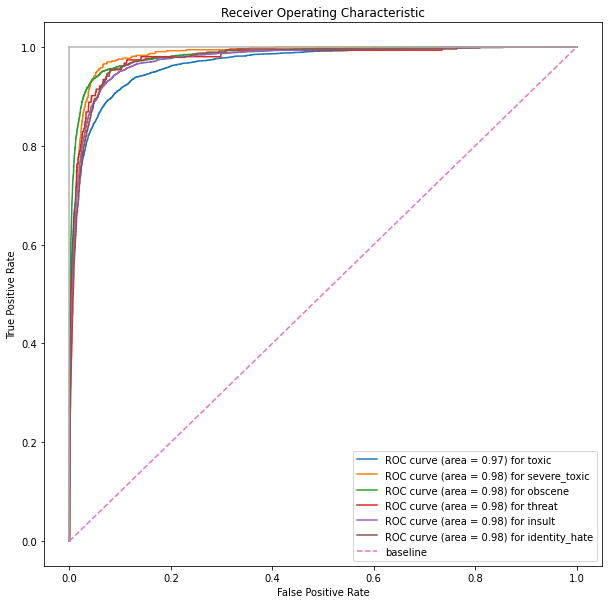

In [100]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label= 'ROC curve (area = %0.2f) for %s' % (roc_auc_scores[i], categories[i]))
plt.plot([0, 1], ls="--", label='baseline')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [101]:
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
print('Average accuracy is {}'.format(avg_accuracy))

avg_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)
print('Average ROC AUC Score is {}'.format(avg_roc_auc))

Average accuracy is 0.979997088183723
Average ROC AUC Score is 0.9773427999725371


In [135]:
# Predict test data
for category in categories:
    test_predictions = multi_label_clf.predict_proba(X_test_sub)
    submissions_df[category] = test_predictions[:, 1]

In [136]:
submissions_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.186549,0.186549,0.186549,0.186549,0.186549,0.186549
1,0000247867823ef7,0.004539,0.004539,0.004539,0.004539,0.004539,0.004539
2,00013b17ad220c46,0.006202,0.006202,0.006202,0.006202,0.006202,0.006202
3,00017563c3f7919a,0.001547,0.001547,0.001547,0.001547,0.001547,0.001547
4,00017695ad8997eb,0.004021,0.004021,0.004021,0.004021,0.004021,0.004021


In [137]:
X_test_sub.head()

0    yo bitch ja rule is more succesful then you wi...
1              from rfc the title is fine as it is imo
2                       sources zawe ashton on lapland
3    if you have a look back at the source the info...
4            i do not anonymously edit articles at all
Name: comment_text, dtype: object

In [138]:
submissions_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.186549,0.186549,0.186549,0.186549,0.186549,0.186549
1,0000247867823ef7,0.004539,0.004539,0.004539,0.004539,0.004539,0.004539
2,00013b17ad220c46,0.006202,0.006202,0.006202,0.006202,0.006202,0.006202
3,00017563c3f7919a,0.001547,0.001547,0.001547,0.001547,0.001547,0.001547
4,00017695ad8997eb,0.004021,0.004021,0.004021,0.004021,0.004021,0.004021


In [139]:
# write test probabilities to submission.csv
submissions_df.to_csv('data/submission.csv', index=False)

In [ ]:
'''
# TODO: Classification Report Multi-Label
# Classification report
model_report = classification_report(y_test, y_pred)
print(model_report)

# TODO: Confusion Matrix Mult-Label
# Confusion Matrix
model_conf = confusion_matrix(y_test, y_pred)
print(model_conf)
'''
pass